In [1]:
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.ticker as plticker
from collections import Counter

In [2]:
keys = pd.read_csv('twitterKeys.csv')
consumer_key = keys['keys'][0]
consumer_secret = keys['keys'][1]
access_token = keys['keys'][2]
access_secret = keys['keys'][3]

In [3]:
authenticate = tweepy.OAuthHandler(consumer_key, consumer_secret) 
authenticate.set_access_token(access_token, access_secret) 
api = tweepy.API(authenticate, wait_on_rate_limit = True)

In [4]:
def getUserPosts(user, number):
    timeline = api.user_timeline(screen_name = user, count = number, lang = "en", tweet_mode = "extended")
    arr = []
    j=1
    for i in timeline[:number]:
        arr.append(i.full_text)
        j += 1
    return arr
def getHashtagPosts(hashtag, num, date = None):
    timeline = list(api.search(hashtag, count = num, lang = 'en', tweet_mode = "extended"))
    arr = []
    j=1
    for i in timeline[:-1]:
        arr.append(i.full_text)
        j += 1
    return arr
def clean(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) 
    text = re.sub('RT[\s]+', '', text) 
    text = re.sub('https?:\/\/\S+', '', text)
 
    return text

In [5]:
def getSubjectivity(df, col):
    arr = []
    for i in df[col]:
        arr.append(TextBlob(i).sentiment.polarity)
    return arr

def getPolarity(df, col):
    arr = []
    for i in df[col]:
        arr.append(TextBlob(i).sentiment.polarity)
    return arr


In [6]:
def analyze(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [7]:
def getSentiment(target, num, date = None):
    if target[0] == '#':
        arr = getHashtagPosts(target, num, date)
        frame = pd.DataFrame(arr, columns = ['Tweets'])
        cleaned = frame['Tweets'].apply(clean)
        cleaned  = cleaned.to_frame()
        cleaned['Subjectivity'] = getSubjectivity(cleaned, 'Tweets')
        cleaned['Polarity'] = getPolarity(cleaned, 'Tweets')
        cleaned['Outcome'] = cleaned['Polarity'].apply(analyze)
    else:
        arr = getUserPosts(target, num)
        frame = pd.DataFrame(arr, columns = ['Tweets'])
        cleaned = frame['Tweets'].apply(clean)
        cleaned  = cleaned.to_frame()
        cleaned['Subjectivity'] = getSubjectivity(cleaned, 'Tweets')
        cleaned['Polarity'] = getPolarity(cleaned, 'Tweets')
        cleaned['Outcome'] = cleaned['Polarity'].apply(analyze)
    return cleaned

In [8]:
def sortdf(dataframe, sorter, order = False):
    return df.sort_values(by=[sorter], ascending = order )

In [9]:
def makeWordPlot(df, col):
    words = ' '.join([t for t in df[col]])
    wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(words)
    plt.imshow(wordCloud, interpolation = "bilinear")
    plt.axis('off')
    plt.show()

In [10]:
def mostCommon(frame, col, start = 0, end = 0):
    arr = frame[col]
    words = ' '.join([t for t in frame[col]])
    most_common = Counter(words.split()).most_common()
    return most_common[start:end]

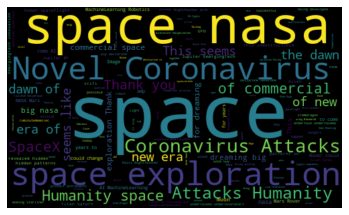

[('#space', 49),
 ('the', 49),
 ('of', 45),
 (':', 33),
 ('#Space', 30),
 ('#nasa', 29),
 ('to', 26),
 ('for', 23),
 ('a', 22),
 ('space', 21),
 ('This', 17),
 ('Coronavirus', 16),
 ('Attacks', 16),
 ('Novel', 15),
 ('Humanity', 15),
 ('on', 15),
 ('is', 14),
 ('commercial', 14),
 ('.', 14),
 ('like', 13)]

In [11]:
df = getSentiment('#space', 1000)
makeWordPlot(df, 'Tweets')
df
mostCommon(df, 'Tweets', 0, 20)

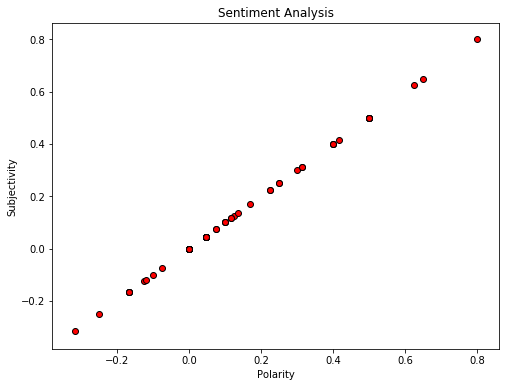

Covariance matrix for polarity and subjectivity:  
 [[0.03912683 0.03912683]
 [0.03912683 0.03912683]]
Pearson's correlation coefficient (for a linear plot) derived from the covariance matrix:  
 1.0


In [12]:
plt.figure(figsize=(8,6)) 
for i in range(0, df.shape[0]):
    plt.scatter(df["Polarity"][i], df["Subjectivity"][i], color='red', edgecolor = 'k') 
plt.title('Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()
cov = np.cov(np.array(df['Polarity']), np.array([df['Subjectivity']]))
print("Covariance matrix for polarity and subjectivity: ", '\n', np.cov(np.array(df['Polarity']), np.array([df['Subjectivity']])))
print("Pearson's correlation coefficient (for a linear plot) derived from the covariance matrix: ", '\n', np.corrcoef(df['Polarity'], df['Subjectivity'])[0,1])

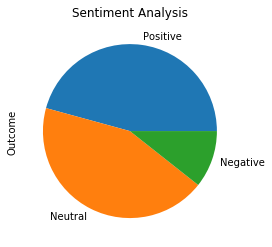

In [13]:
plt.title('Sentiment Analysis')
df['Outcome'].value_counts().plot(kind = 'pie')
plt.show()

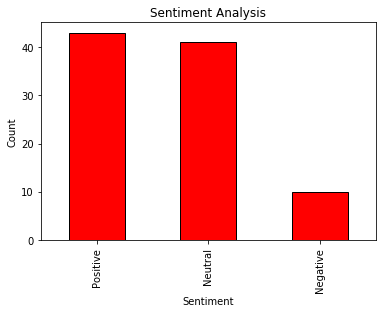

In [14]:
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
df['Outcome'].value_counts().plot(kind = 'bar', color = 'r', edgecolor = 'k')
plt.show()

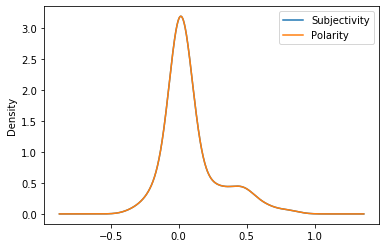

In [15]:
df.plot(kind = 'kde')

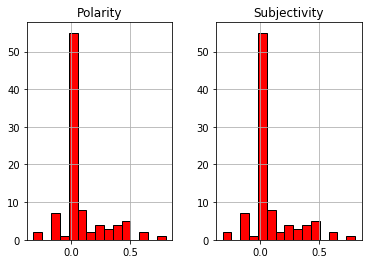

In [16]:
hist = df.hist(bins = 15, color = 'r', edgecolor = 'k')